In [12]:
from google.colab import drive
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

drive.mount('/content/drive')


dataset_path = '/content/drive/MyDrive/sampled_dataset'
csv_file = os.path.join(dataset_path, 'sampled_train_labels.csv')
images_folder = os.path.join(dataset_path, 'images')

labels_df = pd.read_csv(csv_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-13-008bc89c9a07>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=labels_df, palette='Set2')


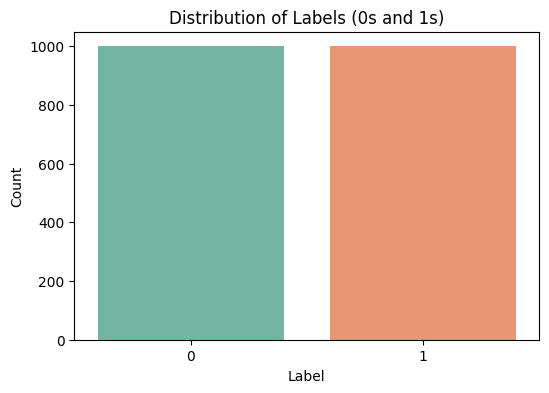

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels_df, palette='Set2')
plt.title('Distribution of Labels (0s and 1s)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


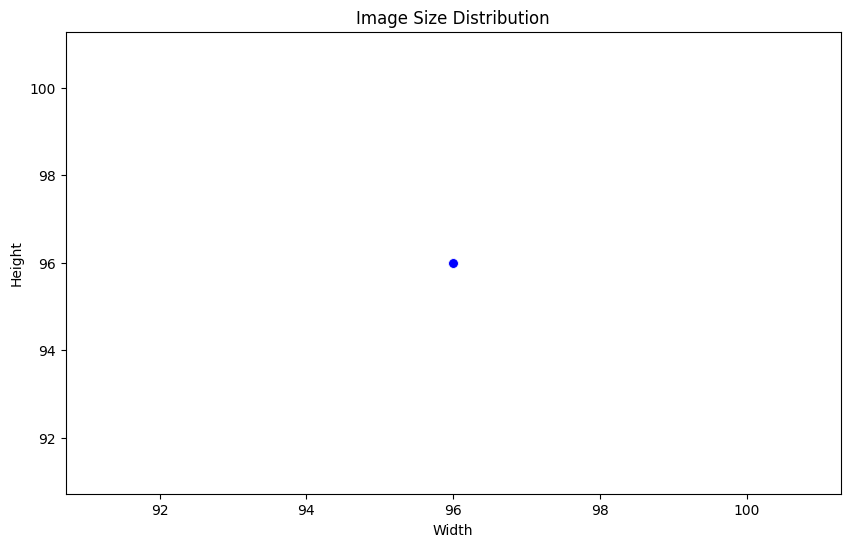

In [14]:
image_sizes = []

for _, row in labels_df.iterrows():
    image_id = row['id']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = Image.open(image_path)
    image_sizes.append(img.size)

size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='width', y='height', data=size_df, s=50, color='blue')
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


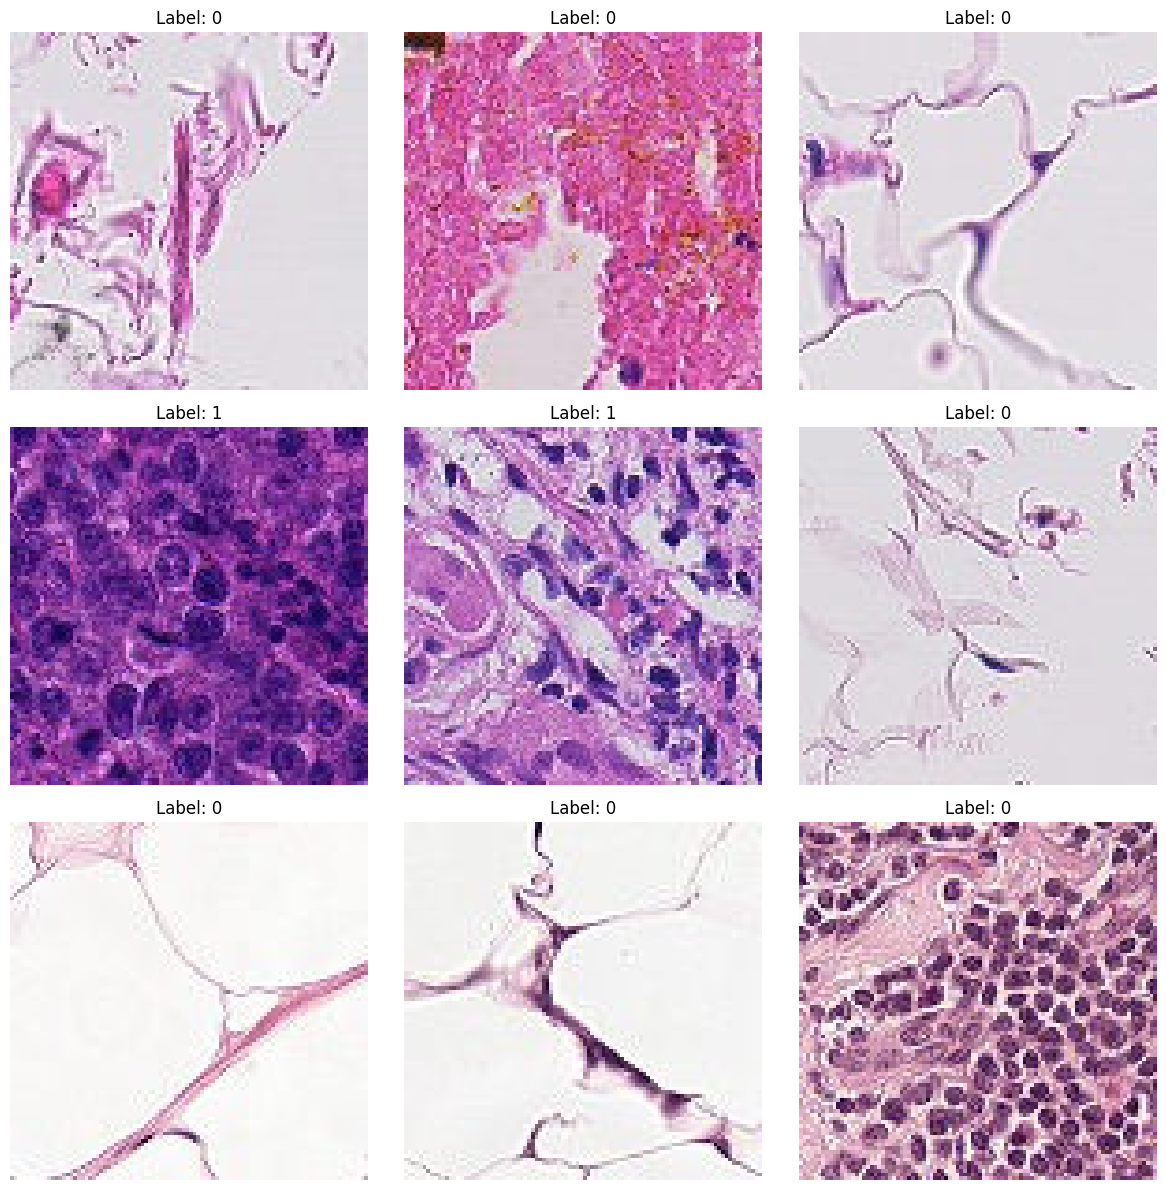

In [15]:
import random
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(9):
    random_index = random.randint(0, len(labels_df) - 1)
    image_id = labels_df.iloc[random_index]['id']
    label = labels_df.iloc[random_index]['label']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = Image.open(image_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


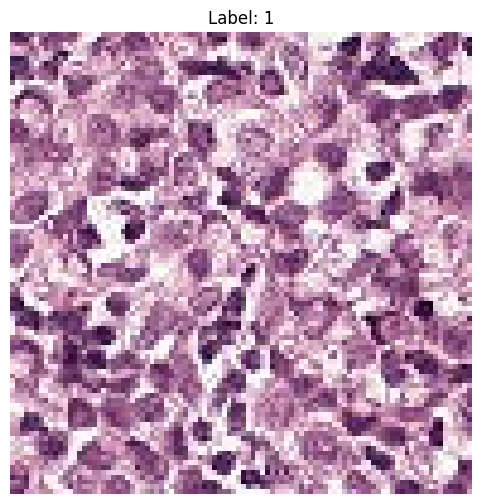

Image saved at: /content/b82614b54a1417c803da3d32bac16d5b4b6274b9.tif


In [16]:
import random
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

random_index = random.randint(0, len(labels_df) - 1)
image_id = labels_df.iloc[random_index]['id']
label = labels_df.iloc[random_index]['label']
image_path = os.path.join(images_folder, f'{image_id}.tif')
img = Image.open(image_path)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

save_path = os.path.join('/content', f'{image_id}.tif')
img.save(save_path)
print(f'Image saved at: {save_path}')


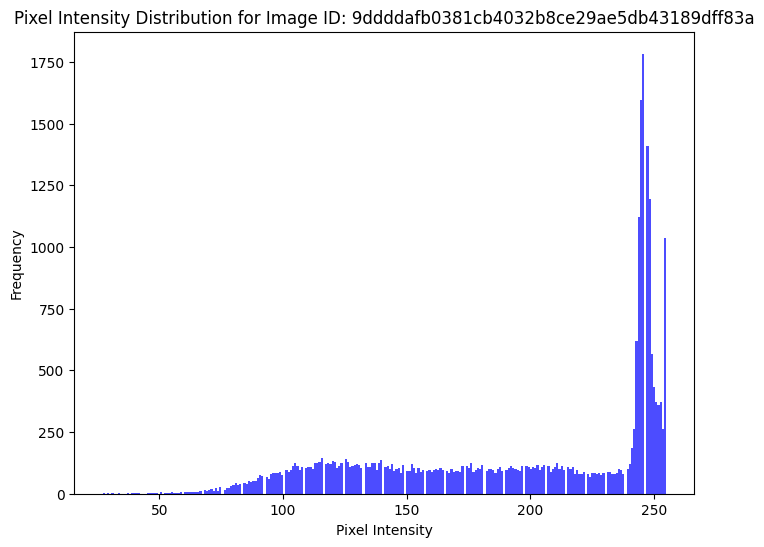

In [17]:
random_image_id = labels_df.sample(1)['id'].values[0]
random_image_path = os.path.join(images_folder, f'{random_image_id}.tif')
random_image = Image.open(random_image_path)
random_image_np = np.array(random_image)

plt.figure(figsize=(8, 6))
plt.hist(random_image_np.ravel(), bins=256, color='blue', alpha=0.7)
plt.title(f'Pixel Intensity Distribution for Image ID: {random_image_id}')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


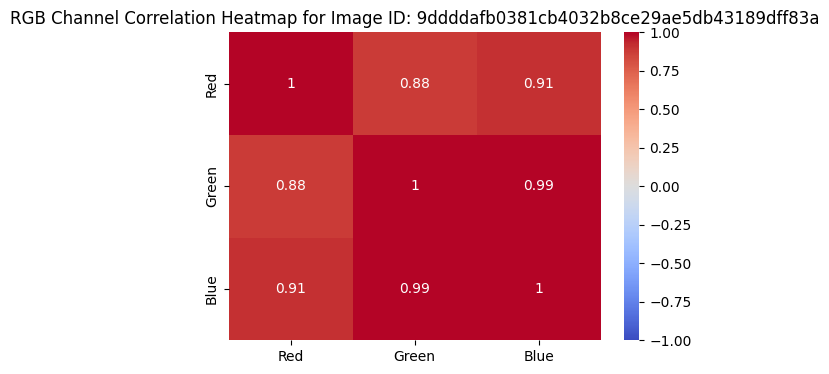

In [18]:
random_image_array = np.array(random_image)

r_channel = random_image_array[:, :, 0].ravel()
g_channel = random_image_array[:, :, 1].ravel()
b_channel = random_image_array[:, :, 2].ravel()

rgb_df = pd.DataFrame({'Red': r_channel, 'Green': g_channel, 'Blue': b_channel})

plt.figure(figsize=(6, 4))
sns.heatmap(rgb_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'RGB Channel Correlation Heatmap for Image ID: {random_image_id}')
plt.show()


<ipython-input-19-b7315b55904e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='mean_intensity', data=intensity_df, palette='Set1')


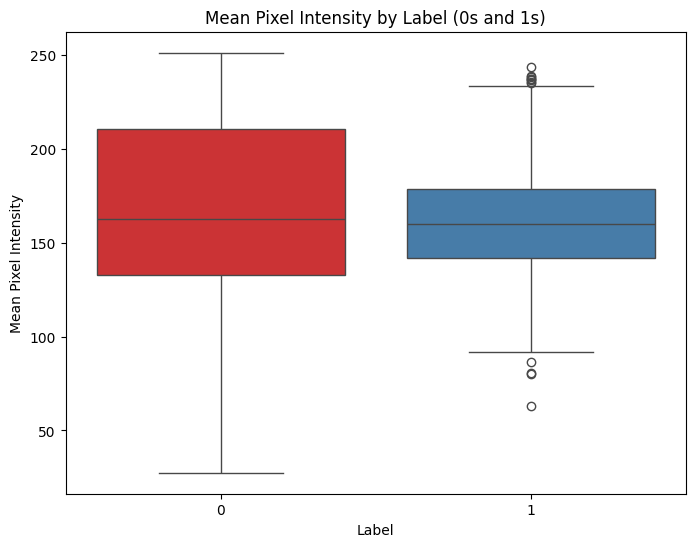

In [19]:
mean_intensity_by_label = []

for _, row in labels_df.iterrows():
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = Image.open(image_path)
    img_array = np.array(img)
    mean_intensity = img_array.mean()
    mean_intensity_by_label.append((label, mean_intensity))

intensity_df = pd.DataFrame(mean_intensity_by_label, columns=['label', 'mean_intensity'])

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='mean_intensity', data=intensity_df, palette='Set1')
plt.title('Mean Pixel Intensity by Label (0s and 1s)')
plt.xlabel('Label')
plt.ylabel('Mean Pixel Intensity')
plt.show()


In [20]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img

images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = preprocess_image(image_path)
    images.append(img)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')

model_save_path = '/content/SDAI.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.5037 - loss: 0.7806 - val_accuracy: 0.6400 - val_loss: 0.6255
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.7034 - loss: 0.6186 - val_accuracy: 0.6850 - val_loss: 0.6295
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.7405 - loss: 0.5879 - val_accuracy: 0.7675 - val_loss: 0.5284
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.7402 - loss: 0.5473 - val_accuracy: 0.7250 - val_loss: 0.5858
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.7686 - loss: 0.5080 - val_accuracy: 0.7625 - val_loss: 0.5247
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.7824 - loss: 0.4905 - val_accuracy: 0.7775 - val_loss: 0.5053
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.7997 - loss: 0.4526 - val_accuracy: 0.7225 - val_loss: 0.5960
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.7953 - loss: 0.4591 - val_accur

Validation accuracy: 76.75%
Model saved at: /content/SDAI.h5


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,636,545 (93.98 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 767ms/step - accuracy: 0.5188 - loss: 0.8861 - val_accuracy: 0.4925 - val_loss: 0.6952
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 618ms/step - accuracy: 0.5006 - loss: 0.6954 - val_accuracy: 0.4800 - val_loss: 0.6924
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 675ms/step - accuracy: 0.5023 - loss: 0.6944 - val_accuracy: 0.4925 - val_loss: 0.6952
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.4942 - loss: 0.6935 - val_accuracy: 0.4925 - val_loss: 0.6930
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step - accuracy: 0.4958 - loss: 0.6940 - val_accuracy: 0.4925 - val_loss: 0.6929
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 700ms/step - accuracy: 0.5172 - loss: 0.6932 - val_accuracy: 0.5150 - val_loss: 0.6926
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step - accuracy: 0.4818 - loss: 0.6943 - val_accuracy: 0.5975 - val_loss: 0.6926
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 617ms/step - accuracy: 0.5097 - loss: 0.6931 - val_accu

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

print(len(model.layers))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


179


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,636,545 (93.98 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.4701 - loss: 0.7794 - val_accuracy: 0.5675 - val_loss: 0.6842
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 626ms/step - accuracy: 0.5074 - loss: 0.7242 - val_accuracy: 0.5925 - val_loss: 0.6781
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 627ms/step - accuracy: 0.5409 - loss: 0.6941 - val_accuracy: 0.5875 - val_loss: 0.6739
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 627ms/step - accuracy: 0.5762 - loss: 0.6752 - val_accuracy: 0.6125 - val_loss: 0.6664
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 626ms/step - accuracy: 0.5805 - loss: 0.6706 - val_accuracy: 0.6100 - val_loss: 0.6692
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 624ms/step - accuracy: 0.6042 - loss: 0.6681 - val_accuracy: 0.5975 - val_loss: 0.6599
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 628ms/step - accuracy: 0.6384 - loss: 0.6503 - val_accuracy: 0.5975 - val_loss: 0.6561
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 724ms/step - accuracy: 0.6213 - loss: 0.6587 - val_accu

In [23]:
import os

cpu_info = os.popen("cat /proc/cpuinfo").read()
print(cpu_info)


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

In [24]:
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img

images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = preprocess_image(image_path)

    images.append(img)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.5230 - loss: 0.6943 - val_accuracy: 0.5325 - val_loss: 0.6839
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.5477 - loss: 0.6848 - val_accuracy: 0.5125 - val_loss: 0.6774
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.5813 - loss: 0.6783 - val_accuracy: 0.6950 - val_loss: 0.6614
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.6139 - loss: 0.6633 - val_accuracy: 0.6325 - val_loss: 0.6502
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.6331 - loss: 0.6539 - val_accuracy: 0.6500 - val_loss: 0.6354
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.6070 - loss: 0.6544 - val_accuracy: 0.6400 - val_loss: 0.6367
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.6425 - loss: 0.6376 - val_accuracy: 0.7225 - val_loss: 0.6190
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.6359 - loss: 0.6496 - val_accur

In [25]:
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img

images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(images_folder, f'{image_id}.tif')
    img = preprocess_image(image_path)

    images.append(img)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.5154 - loss: 0.8646 - val_accuracy: 0.5400 - val_loss: 0.6828
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.5980 - loss: 0.6716 - val_accuracy: 0.7250 - val_loss: 0.6080
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.6701 - loss: 0.6035 - val_accuracy: 0.6900 - val_loss: 0.5738
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.6912 - loss: 0.5909 - val_accuracy: 0.7350 - val_loss: 0.5268
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.7170 - loss: 0.5805 - val_accuracy: 0.6050 - val_loss: 0.6772
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.7334 - loss: 0.5571 - val_accuracy: 0.7225 - val_loss: 0.5451
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.7378 - loss: 0.5339 - val_accuracy: 0.7150 - val_loss: 0.5419
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.7752 - loss: 0.5064 - val_accur

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 670ms/step - accuracy: 0.5388 - loss: 0.8233 - val_accuracy: 0.6150 - val_loss: 0.6842
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - accuracy: 0.5291 - loss: 0.6929 - val_accuracy: 0.5875 - val_loss: 0.6833
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 675ms/step - accuracy: 0.5279 - loss: 0.6892 - val_accuracy: 0.5975 - val_loss: 0.6787
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 718ms/step - accuracy: 0.5661 - loss: 0.6838 - val_accuracy: 0.5650 - val_loss: 0.6768
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 622ms/step - accuracy: 0.5813 - loss: 0.6801 - val_accuracy: 0.5650 - val_loss: 0.6768
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 624ms/step - accuracy: 0.5716 - loss: 0.6774 - val_accuracy: 0.5600 - val_loss: 0.6739
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 729ms/step - accuracy: 0.6067 - loss: 0.6656 - val_accuracy: 0.6425 - val_loss: 0.6607
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 624ms/step - accuracy: 0.6064 - loss: 0.6649 - val_accu